# Predicting Multi-MNIST digits. AML Assignment 2 Matteo Breganni 869549

The assignment consists of three tasks:

1. A multi-class classification problem: the prediction of grayscale images of double-digit numbers from a custom version of the (Multi-)MNIST dataset.

2. Unsupervised problem: the implementation of an AutoEncoder model for the encoding and reconstruction of the provided data.

3. You can choose between (one of them is mandatory, you can choose which one to do):

*   Use latent representation of autoencoder as a feature reduction
*   Explain Neural Network predictions


The dataset is created by simply concatenating pairs of MNIST digits, and the number of classes (originally all the numbers in the [0, 100] range) has been reduced.

An example of the provided dataset is the following:

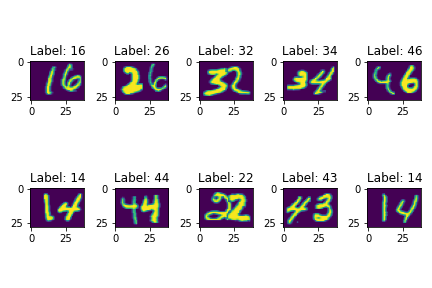

The provided data comprises the training set that can be used for the training (and for the validation) and the test set.

**General considerations**

Always describe and give proper motivations about the choices made during the assignment, including (but not limited to)

- data processing,
- network design: including number and dimension of the layers, regularization techniques (when requested).
- optimization algorithms, including hyperameters and criterions,
- model training hyperparameters
- loss/metric curves
- final evaluations and comparisons.


**Note**: Make sure that the outputs in the notebook cells are still visible once the notebook is exported (especially for html embeddings)

**Note**: Make sure that the submitted *.zip archives are not corrupted.

**Note**: convolutional layers should not be used all over this notebook (with the exception of the optional part).

##Inspecting and preparing the data

In [1]:
import pandas as pd
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt

# Google drive mount
drive.mount('/content/drive')

# Load the .npy files as numpy arrays
X_train_import = np.load("/content/drive/MyDrive/Colab Notebooks/Advanced Machine Learning/Assignment 2/x_train.npy")
y_train_import = np.load("/content/drive/MyDrive/Colab Notebooks/Advanced Machine Learning/Assignment 2/y_train.npy")
X_test_import = np.load("/content/drive/MyDrive/Colab Notebooks/Advanced Machine Learning/Assignment 2/x_test.npy")
y_test_import = np.load("/content/drive/MyDrive/Colab Notebooks/Advanced Machine Learning/Assignment 2/y_test.npy")


X_train_import.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(72247, 28, 39)

There are 72'247 images in the set. Each one is 28x39 pixels.

In [5]:
has_nan = np.isnan(X_train_import).any()
print(has_nan)
has_nan = np.isnan(y_train_import).any()
print(has_nan)
has_nan = np.isnan(X_test_import).any()
print(has_nan)
has_nan = np.isnan(y_test_import).any()
print(has_nan)

False
False
False
False


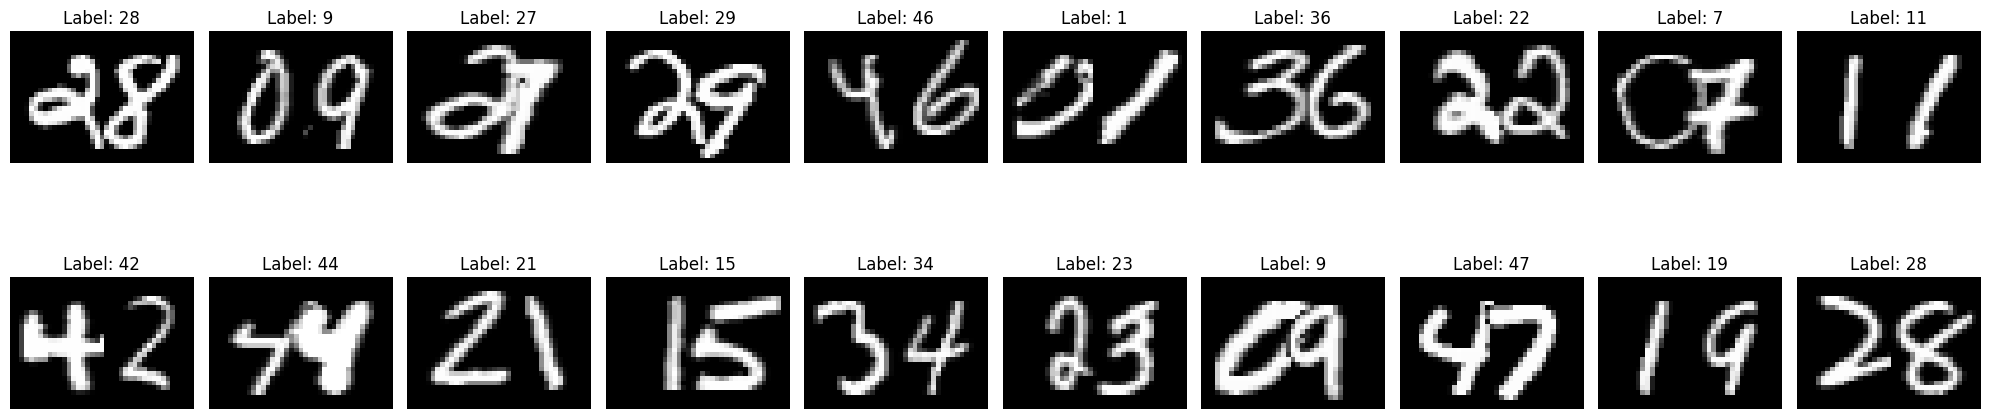

In [6]:
# Set up a 2x10 grid for the subplots
fig, axes = plt.subplots(2, 10, figsize=(20, 6))  # 2 rows, 10 columns

# Loop through the first 20 images and their corresponding labels
for i in range(20):
    ax = axes[i // 10, i % 10]  # Access each subplot in a 2x10 grid
    ax.imshow(X_train_import[i].reshape(28, 39), cmap='gray')  # Reshape to (28, 39) if that's the size
    ax.set_title(f"Label: {y_train_import[i]}")  # Display the label on the image
    ax.axis('off')  # Turn off axis for cleaner display

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

From these examples I can note that numbers like 09 and 01 are labelled without the 0. This is probably not a problem, but it's something to keep an eye on for later.

In [7]:
print("Mean:", np.mean(X_train_import[0]))
print("Min:", np.min(X_train_import[0]))
print("Max:", np.max(X_train_import[0]))

Mean: 55.43681318681319
Min: 0
Max: 255


This confirms that every image is a grayscale image, where each pixel is the 8-bit level of gray, so the range is 0-255.

In [8]:
print("Mean:", np.mean(y_train_import))
print("Min:", np.min(y_train_import))
print("Max:", np.max(y_train_import))

Mean: 25.310518083795866
Min: 1
Max: 50


This shows that the labels are a number from 1 to 50.

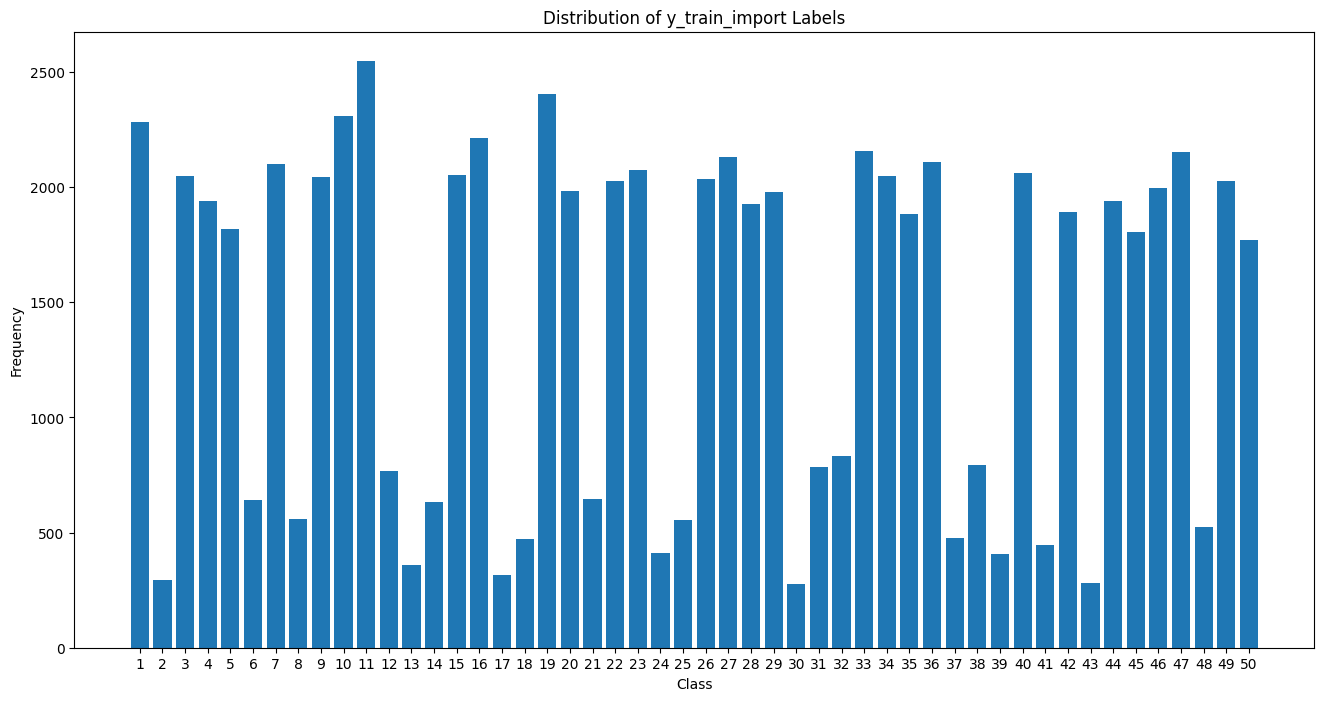

In [9]:
# Plot the distribution of the y_train_import labels
# Ensure correct binning
unique_values = np.unique(y_train_import)
plt.figure(figsize=(16, 8))

# Explicitly setting the bins to cover all unique values
plt.hist(y_train_import, bins=np.arange(min(unique_values), max(unique_values) + 2) - 0.5, rwidth=0.8)
plt.title('Distribution of y_train_import Labels')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(np.arange(min(unique_values), max(unique_values) + 1))

plt.show()

Some classes have notably higher frequencies than others. There are also classes with much lower frequencies, indicating an imbalance in the dataset.

This kind of uneven distribution can impact the model's training, since classes with fewer samples may not be learned as well by the model.

In [10]:
from tensorflow.keras.utils import to_categorical
# Reshaping the training & test sets

X_train = X_train_import.reshape(X_train_import.shape[0], X_train_import.shape[1]*X_train_import.shape[2])
X_test = X_test_import.reshape(X_test_import.shape[0], X_test_import.shape[1]*X_test_import.shape[2])

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

y_train = to_categorical(y_train_import-1)
y_test = to_categorical(y_test_import-1)

This reshapes each one of the image samples in the training and test sets from a 2D image where the second and third dimensions of the matrix represent the height (28 pixels) and width (39 pixels), into a one dimensional vector.

Then, each array is converted to float32 and normalized into a 0-1 range.

Lastly, the labels of the training set and the test set are one-hot encoded.

Regarding the one-hot encoding, I have considered taking a different approach, instead of giving a separated category to each different two-digit number. I have thought about the possibility of having 10 output nodes, one for each digit, and then taking the 2 with the highest probability as the two-digit number. However, I have realized that, although this could potentially work better, it would eliminate the ordinality of the two numbers, so it would be a solution for a different problem. Another way to create a better model would be to have an algotithm that splits the image into each single digit, so that each one can be analyzed singularly by the model, but this would be complicated and not what is requested in the assignment. Otherwise, just having 2 targets for each digit could work much better, but here again, I'm not sure if this is outside of the scope of the assignment so I decided to not attempt it.

Although I decided to go for the more direct and normal approach of having 51 output classes, I still wanted to include my thought process.

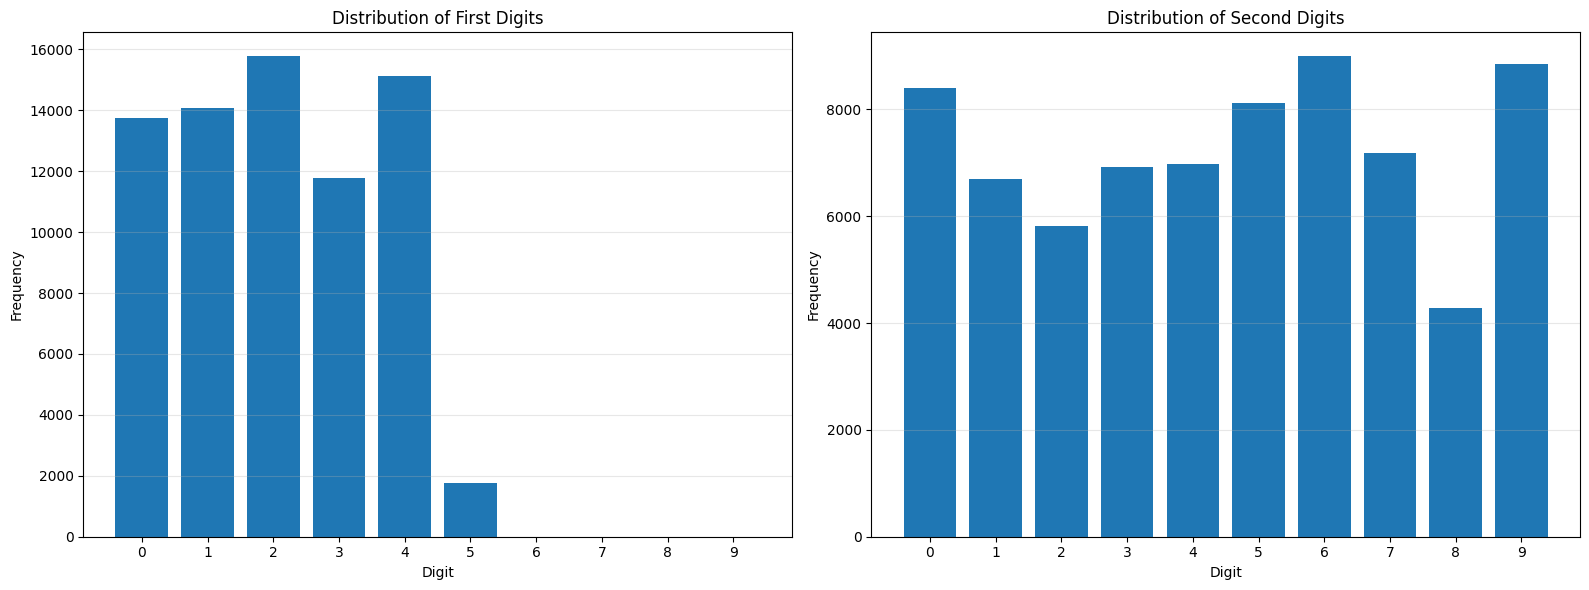

In [11]:
def get_first_second_digits(number):
    """Extract first and second digits from a number"""
    str_num = str(number).zfill(2)  # Pad with leading zero if needed
    return int(str_num[0]), int(str_num[1])

# Collect first and second digits separately
first_digits = []
second_digits = []
for number in y_train_import:
    first, second = get_first_second_digits(number)
    first_digits.append(first)
    second_digits.append(second)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bins for digits 0-9
bins = np.arange(-0.5, 10.5, 1)

# Plot first digits
ax1.hist(first_digits, bins=bins, rwidth=0.8)
ax1.set_title('Distribution of First Digits')
ax1.set_xlabel('Digit')
ax1.set_ylabel('Frequency')
ax1.set_xticks(range(10))
ax1.grid(True, axis='y', alpha=0.3)

# Plot second digits
ax2.hist(second_digits, bins=bins, rwidth=0.8)
ax2.set_title('Distribution of Second Digits')
ax2.set_xlabel('Digit')
ax2.set_ylabel('Frequency')
ax2.set_xticks(range(10))
ax2.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

If considered separatelly, the distribution of the first and second digit seem much more well distributed. This is another indication that a model that separates the two digits and considers them separatelly might work much better.

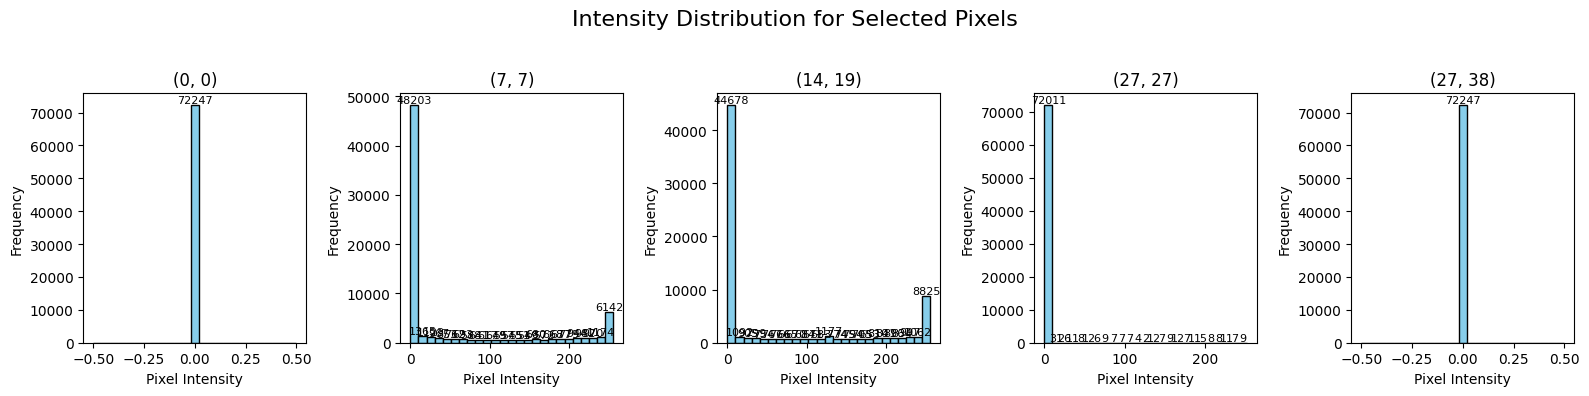

In [12]:
# Shows the intensity distribution for selected pixels, across all images
pixels_to_plot = [(0, 0), (7, 7), (14, 19), (27, 27), (27, 38)]

plt.figure(figsize=(16, 4))
plt.suptitle("Intensity Distribution for Selected Pixels", fontsize=16)

for i, (row, col) in enumerate(pixels_to_plot, 1):
    pixel_values = X_train_import[:, row, col]  # Extract pixel values for all images at this position
    ax = plt.subplot(1, len(pixels_to_plot), i)

    # Plot the histogram and get the bins and frequencies
    counts, bins, patches = ax.hist(pixel_values, bins=25, color='skyblue', edgecolor='black')

    # Annotate each bin with its frequency
    for count, x in zip(counts, bins):
        if count > 0:  # Only label bars with a non-zero count
            ax.text(x + (bins[1] - bins[0]) / 2, count, int(count), ha='center', va='bottom', fontsize=8)

    # Titles and labels
    ax.set_title(f"({row}, {col})")
    ax.set_xlabel("Pixel Intensity")
    ax.set_ylabel("Frequency")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

These plots show the distribution of the pixel intensity of certain pixels, across all images.

I have plotted these to show how (as I expected) distributions can differ based on what pixel we're considerating.

For example, (0,0) is the top-left pixel and (27,38) is the bottom-right pixel, and they always have a value of 0.

On the other hand, (14,19), is the pixel in the middle of the image and (7,7) is another random pixel, that have a very different distribution, still with most 0s but quite a few 1s and values in the middle too.

Another case is (27,27), which is an edge pixel that is almost always 0, but not always.

I have plotted these distribution to show that different pixels can give a differnt kind and different amount of information. For example, we could easily exclude the two corner pixel since they don't provide any information. On the other hand, edge pixels like (27,27) could either not give enough information since only a few images have values in those regions, or they could be important to distinguish between different numbers.

I will not attempt to remove any feature at this point, since the last optional part of the assignment is regarding the model explainability, and if I decide to do that part, it will be interesting to see if my assuptions are correct.

In [13]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

Of course I also had to split the given training set into a training and a validation set, because it's not correct to use the test set for the validation of the model during training, because assuptions about regularization (overfitting, underfitting) are made based on what the validation set shows.

# 1. The resolution of the problem of supervised classification with traditional fully-connected neural networks. [Mandatory]





You are required to implement two models, without and with the use of one (or more) regularization technique of your choice, and to compare their behaviours, in terms of training dynamics and generalization capabilities.

## 1.1 Non-regularized Model

In this section, you are required to attempt to solve the classification task with the implementation and training of a standard fully-connected Neural Network, without the use of any specific regularization technique.

### 1.1.1 Building the network


any description/comment about the procedure you followed in the choice of the network structure and hyperparameters goes here, together with consideration about the training/optimization procedure (e.g. loss/optimizer choice, final activations, loss functions, training metrics and training hyperparameters)

In [36]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Input

input_shape = X_train.shape[1]  # Get the number of features
print('Input Shape =', input_shape)
output_shape = y_train.shape[1] # Get the number of labels
print('Output Shape =', output_shape)

model = Sequential()
model.add(Input((input_shape,)))

# First dense block
model.add(Dense(128))
model.add(Activation('relu'))

# Second dense block
model.add(Dense(128))
model.add(Activation('relu'))

# Third dense block
model.add(Dense(128))
model.add(Activation('tanh'))

# Output layer
model.add(Dense(output_shape, activation='softmax'))

Input Shape = 1092
Output Shape = 50


(these choices could be improved with more testing, given the size of the dataset and the limited GPU time on colab, it takes a lot of time to try different possibilities and find the perfect choices)

Regarding the size of this model, I increased the number of layers and the number of neurons until it seemed like there wasn't any gain from adding more.

Relu is a good starting point and it works well, tanh seemed to improve the model if put in the last layer (it potentially captures different feature distributions, and on the last layer it doesn't cause issues)

Sigmoid was chosen since the dataset requires predicting multiple classes, and softmax ensures the output sums to 1, giving a clear probability distributions.

In [37]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │         139,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 50)                  │           6,450 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 179,378 (700.70 KB)

 Trainable params: 179,378 (700.70 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])

Adam was chosen for its simplicity, given the adaptive learning rate. I have tried other options like SGD, reaching very similar results, in this case adam is simply easier to use and to try different combinations with, since it doesn't require tuning.

Since the output labels have been one-hot encoded, categorical_crossentropy is the appropriate loss function.

Accuracy provides a clear measure of how well the model is performing.

### 1.1.2 Analyze and comment on thetraining results

Describe, visualize and interpret the training history and the resulting training dynamics.

In [39]:
# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=64)

Epoch 1/50
904/904 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6172 - loss: 1.4602 - val_accuracy: 0.8588 - val_loss: 0.4747
Epoch 2/50
904/904 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8783 - loss: 0.4137 - val_accuracy: 0.8965 - val_loss: 0.3500
Epoch 3/50
904/904 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9173 - loss: 0.2703 - val_accuracy: 0.9084 - val_loss: 0.3024
Epoch 4/50
904/904 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9364 - loss: 0.2024 - val_accuracy: 0.9183 - val_loss: 0.2749
Epoch 5/50
904/904 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9476 - loss: 0.1665 - val_accuracy: 0.9212 - val_loss: 0.2641
Epoch 6/50
904/904 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9595 - loss: 0.1288 - val_accuracy: 0.9210 - val_loss: 0.2769
Epoch 7/50
904/904 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9628 - loss: 0.1142 - val_accuracy: 0.9204 - val_loss: 0.2776
Epoch 8/50
904/904 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9698 - loss: 0.0927 - val_accuracy

### 1.1.3 Validate the model and comment on the results

please describe and interpret the evaluation procedure on a **validation set**, including initial comments on the generalization capability of your model (e.g. under/overfitting).

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
# Get predictions (probabilities) from the model
y_pred_prob = model.predict(X_val)

# Convert probabilities to predicted class labels (the class with the highest probability)
y_pred = np.argmax(y_pred_prob, axis=1)  # Get the index of the class with the highest probability

# Convert y_val (one-hot encoded) to class labels
y_val_labels = np.argmax(y_val, axis=1)

452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


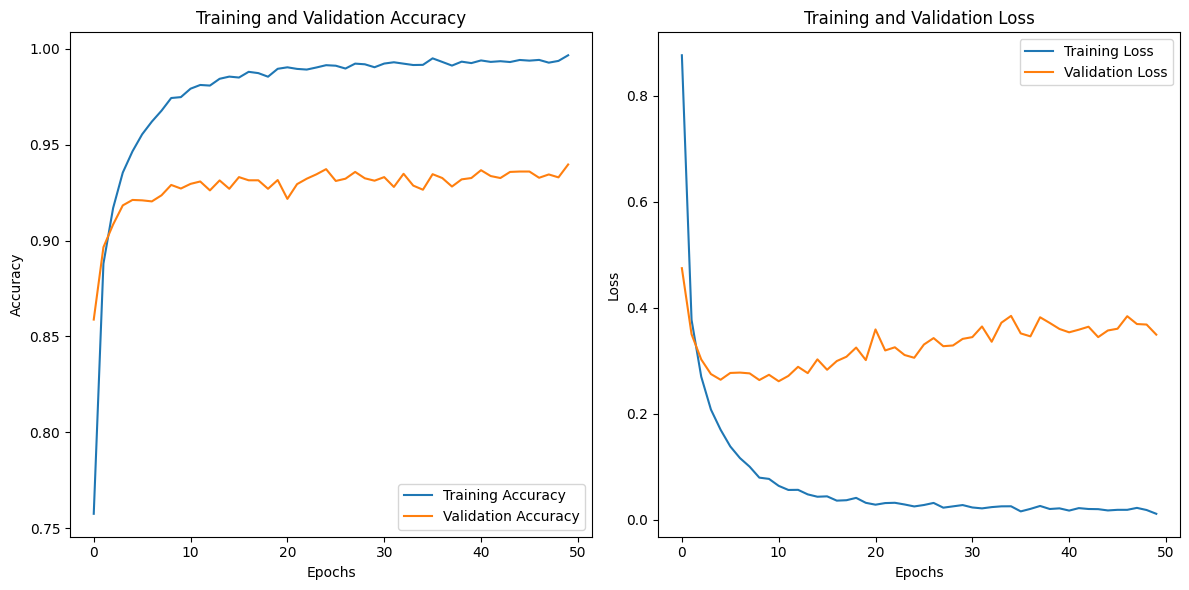

In [41]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

The training accuracy quickly increases, indicating that the model is learning the training data well, but given the gap between the training and the validation curves, the model is definitely overfitting the training data.

In [42]:
# Print classification report
print(classification_report(y_val_labels, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       484
           1       0.78      0.82      0.80        74
           2       0.93      0.95      0.94       424
           3       0.99      0.91      0.95       364
           4       0.93      0.95      0.94       364
           5       0.94      0.90      0.92       112
           6       0.93      0.95      0.94       396
           7       0.94      0.78      0.85       114
           8       0.91      0.96      0.93       418
           9       0.97      0.97      0.97       445
          10       0.98      0.98      0.98       524
          11       0.92      0.95      0.93       150
          12       0.88      0.87      0.88        69
          13       0.91      0.97      0.94       124
          14       0.97      0.96      0.97       397
          15       0.97      0.97      0.97       449
          16       0.91      0.90      0.90        68
          17       0.93    

regardless, the results are pretty good. I will comment them more in the appropriate section later.

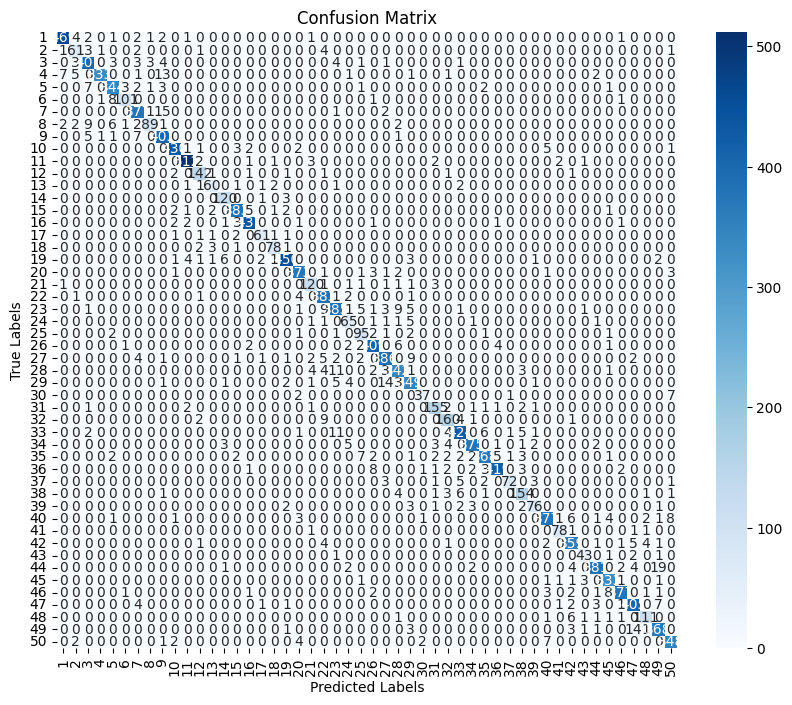

In [43]:
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_val_labels, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1, 51), yticklabels=np.arange(1, 51))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

The results look good, I will comment them better later.

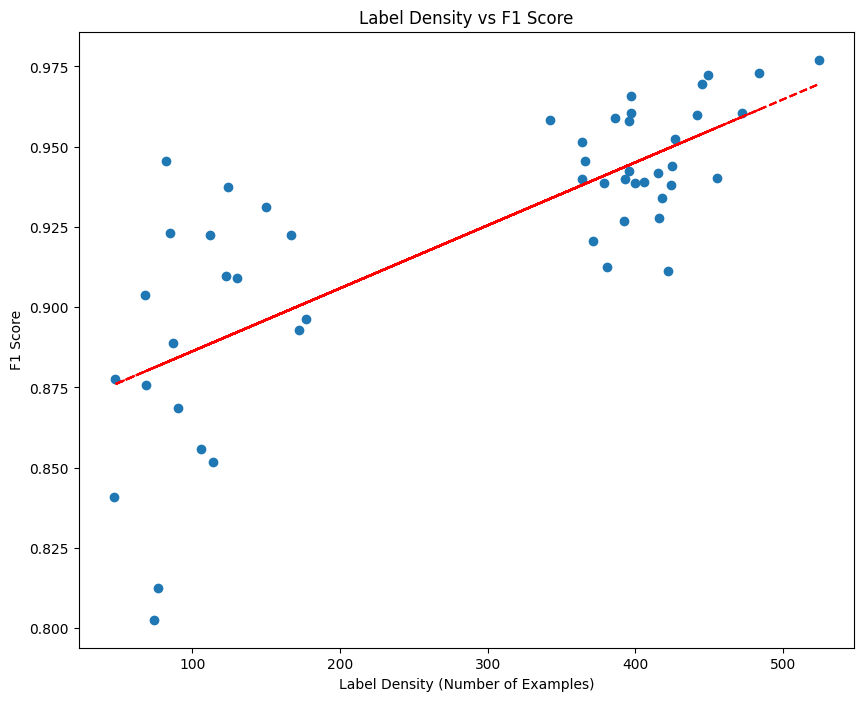

In [44]:
# Get the classification report
report = classification_report(y_val_labels, y_pred, output_dict=True)

# Extract the label names, F1 scores, and support (label density)
labels = list(report.keys())[:-3]
f1_scores = [report[label]['f1-score'] for label in labels]
supports = [report[label]['support'] for label in labels]

# Create the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(supports, f1_scores)

# Add labels and title
plt.xlabel('Label Density (Number of Examples)')
plt.ylabel('F1 Score')
plt.title('Label Density vs F1 Score')

# Add a trend line
z = np.polyfit(supports, f1_scores, 1)
p = np.poly1d(z)
plt.plot(supports, p(supports), color='r', linestyle='--')

# Show the plot
plt.show()

I have plotted this to confirm a suspicion that I noticed in the classification report, since classes with less examples seemed to have a lower accuracy on average.

From this plot we can conferm this trend. In the next section, I have attempted an undersampling approach that didn't work.

#### Model 2 (undersampling failed attempt)

Notes about this whole section:

Considering the results of the previous model, and especially the last plot, I have attempted to undersample the training set (not the validation set) to balance the labels of the training examples.

However, did this not make the results better, and actually had the opposite effect that I intented. The more I balanced the training set (I tried different max sizes for each label, all the way down to 200 where every label is balanced), the more the performance got worse.

This probably means that the unbalance itself didn't cause the performance reduction, but instead it's cause by the underrepresentation of some of the labels in the training set, that simply doesn't give the model enough examples to learn that class.

For these reasons, I'm keeping the first model for this section.

In [45]:
from collections import Counter

# Convert one-hot encoded y_train to class indices
y_train_indices = np.argmax(y_train, axis=1)

# Get counts per class and initialize list for keeping indices
class_counts = Counter(y_train_indices)
indices_to_keep = []

# For each class, select up to 200 samples
for class_label in class_counts:
    class_indices = np.where(y_train_indices == class_label)[0]

    if len(class_indices) > 200:
        selected_indices = np.random.choice(class_indices, size=200, replace=False)
    else:
        selected_indices = class_indices

    indices_to_keep.extend(selected_indices)

# Shuffle the indices
np.random.shuffle(indices_to_keep)

# Create undersampled dataset
X_train_undersampled = X_train[indices_to_keep]
y_train_undersampled = y_train[indices_to_keep]

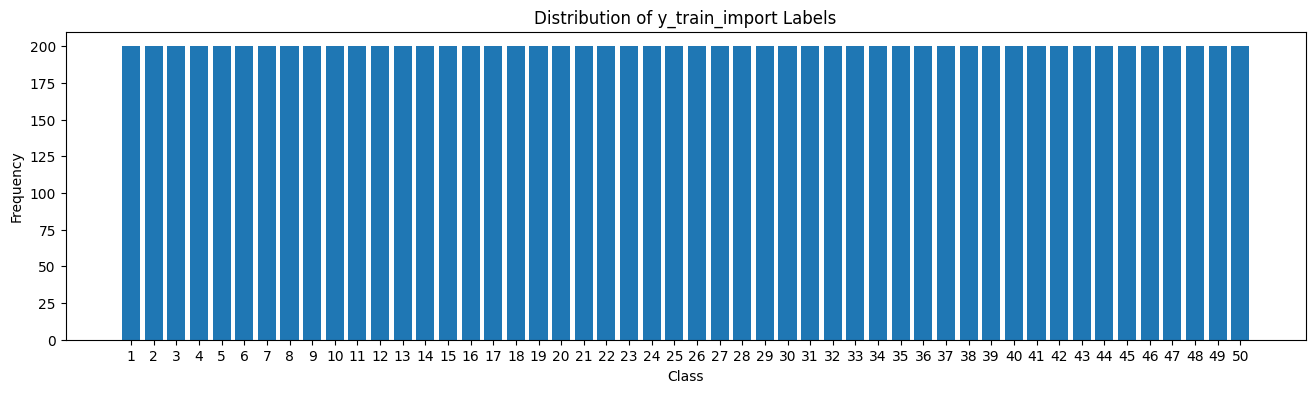

In [46]:
# Plot the distribution of the y_train_import labels
# Ensure correct binning
y_train_indices = np.argmax(y_train_undersampled, axis=1) + 1
unique_values = np.unique(y_train_indices)
plt.figure(figsize=(16, 4))

# Explicitly setting the bins to cover all unique values
plt.hist(y_train_indices, bins=np.arange(min(unique_values), max(unique_values) + 2) - 0.5, rwidth=0.8)
plt.title('Distribution of y_train_import Labels')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(np.arange(min(unique_values), max(unique_values) + 1))

plt.show()

In [47]:
model2 = Sequential()
model2.add(Input((input_shape,)))

# First dense block
model2.add(Dense(128))
model2.add(Activation('relu'))

# Second dense block
model2.add(Dense(128))
model2.add(Activation('relu'))

# Third dense block
model2.add(Dense(128))
model2.add(Activation('tanh'))

# Output layer
model2.add(Dense(output_shape, activation='softmax'))

In [48]:
model2.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [49]:
# Train the model
history2 = model2.fit(X_train_undersampled, y_train_undersampled,
                    validation_data=(X_val, y_val),
                    epochs=25,
                    batch_size=64)

Epoch 1/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2750 - loss: 2.9135 - val_accuracy: 0.6952 - val_loss: 1.1177
Epoch 2/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7424 - loss: 0.9486 - val_accuracy: 0.7677 - val_loss: 0.8202
Epoch 3/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8131 - loss: 0.6768 - val_accuracy: 0.8049 - val_loss: 0.6817
Epoch 4/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8580 - loss: 0.5164 - val_accuracy: 0.8161 - val_loss: 0.6195
Epoch 5/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8918 - loss: 0.3981 - val_accuracy: 0.8352 - val_loss: 0.5567
Epoch 6/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9189 - loss: 0.3101 - val_accuracy: 0.8355 - val_loss: 0.5464
Epoch 7/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9359 - loss: 0.2418 - val_accuracy: 0.8500 - val_loss: 0.5040
Epoch 8/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9584 - loss: 0.1820 - val_accura

In [50]:
from sklearn.metrics import classification_report, confusion_matrix
# Get predictions (probabilities) from the model
y_pred_prob2 = model2.predict(X_val)

# Convert probabilities to predicted class labels (the class with the highest probability)
y_pred2 = np.argmax(y_pred_prob2, axis=1)  # Get the index of the class with the highest probability

# Convert y_val (one-hot encoded) to class labels
y_val_labels = np.argmax(y_val, axis=1)

452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


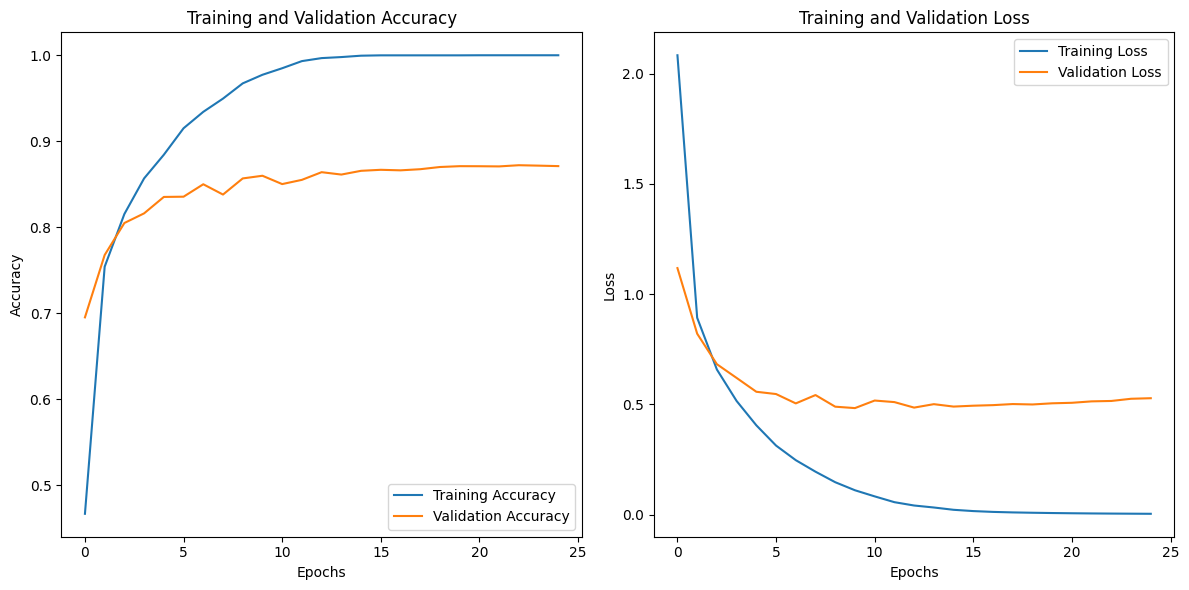

In [51]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [52]:
# Print classification report
print(classification_report(y_val_labels, y_pred2))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       484
           1       0.66      0.88      0.75        74
           2       0.91      0.86      0.88       424
           3       0.94      0.84      0.89       364
           4       0.92      0.85      0.88       364
           5       0.77      0.88      0.82       112
           6       0.85      0.89      0.87       396
           7       0.64      0.81      0.71       114
           8       0.87      0.83      0.85       418
           9       0.95      0.95      0.95       445
          10       0.98      0.94      0.96       524
          11       0.85      0.89      0.87       150
          12       0.60      0.87      0.71        69
          13       0.79      0.98      0.87       124
          14       0.94      0.86      0.90       397
          15       0.94      0.94      0.94       449
          16       0.73      0.90      0.81        68
          17       0.79    

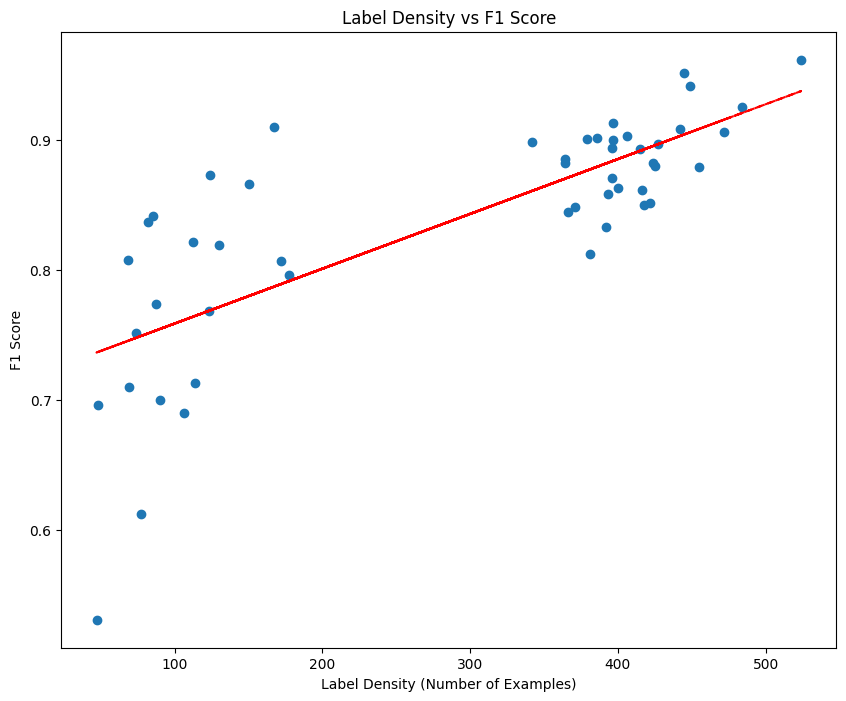

In [53]:
# Get the classification report
report = classification_report(y_val_labels, y_pred2, output_dict=True)

# Extract the label names, F1 scores, and support (label density)
labels = list(report.keys())[:-3]
f1_scores = [report[label]['f1-score'] for label in labels]
supports = [report[label]['support'] for label in labels]

# Create the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(supports, f1_scores)

# Add labels and title
plt.xlabel('Label Density (Number of Examples)')
plt.ylabel('F1 Score')
plt.title('Label Density vs F1 Score')

# Add a trend line
z = np.polyfit(supports, f1_scores, 1)
p = np.poly1d(z)
plt.plot(supports, p(supports), color='r', linestyle='--')

# Show the plot
plt.show()

## 1.2 Regularized Model

Replicate the structure of section 1.1 (including subsections 1.1.1, 1.1.2, 1.1.3 and guidelines), this time with the implementation and training of a regularized network.

Implement _at least_ one regularization technique of your choice.

The overall model architecture can be either identical or different with respect to the one presented in sec 1.1 (your choice).

In [54]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2

model3 = Sequential()
model3.add(Input((input_shape,)))

# First dense block
model3.add(Dense(128, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001)))
model3.add(Activation('relu'))
model3.add(Dropout(0.20))

# Second dense block
model3.add(Dense(128, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001)))
model3.add(Activation('relu'))
model3.add(Dropout(0.20))

# Third dense block
model3.add(Dense(128, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001)))
model3.add(Activation('tanh'))
model3.add(Dropout(0.20))

# Output layer
model3.add(Dense(output_shape, activation='softmax'))

I have decided to maintain the same network structure, to better see the differences.

Dropouts are tuned to reduce, and eliminate, all the overfitting that was visible in the previous model.

I've added a little l2 kernel regularization (it worked well in this case) to disincentivize big weights.

In [55]:
model3.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=9, restore_best_weights=True)

I have added early stopping with a patience of 9. I could be quite high, but this way it avoids stopping the model too early, while still avoiding the training running needlessly long.

In [56]:
# Train the model
history3 = model3.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=128,
                    callbacks=[early_stopping])

Epoch 1/100
452/452 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.4511 - loss: 2.1385 - val_accuracy: 0.8320 - val_loss: 0.6445
Epoch 2/100
452/452 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7902 - loss: 0.7679 - val_accuracy: 0.8746 - val_loss: 0.4866
Epoch 3/100
452/452 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8455 - loss: 0.5903 - val_accuracy: 0.8926 - val_loss: 0.4263
Epoch 4/100
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8682 - loss: 0.5071 - val_accuracy: 0.9092 - val_loss: 0.3836
Epoch 5/100
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8847 - loss: 0.4539 - val_accuracy: 0.9136 - val_loss: 0.3659
Epoch 6/100
452/452 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8973 - loss: 0.4180 - val_accuracy: 0.9198 - val_loss: 0.3467
Epoch 7/100
452/452 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9031 - loss: 0.3922 - val_accuracy: 0.9249 - val_loss: 0.3324
Epoch 8/100
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9102 - loss: 0.3751 - 

In [57]:
# Get predictions (probabilities) from the model
y_pred_prob3 = model3.predict(X_val)

# Convert probabilities to predicted class labels (the class with the highest probability)
y_pred3 = np.argmax(y_pred_prob3, axis=1)  # Get the index of the class with the highest probability

452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


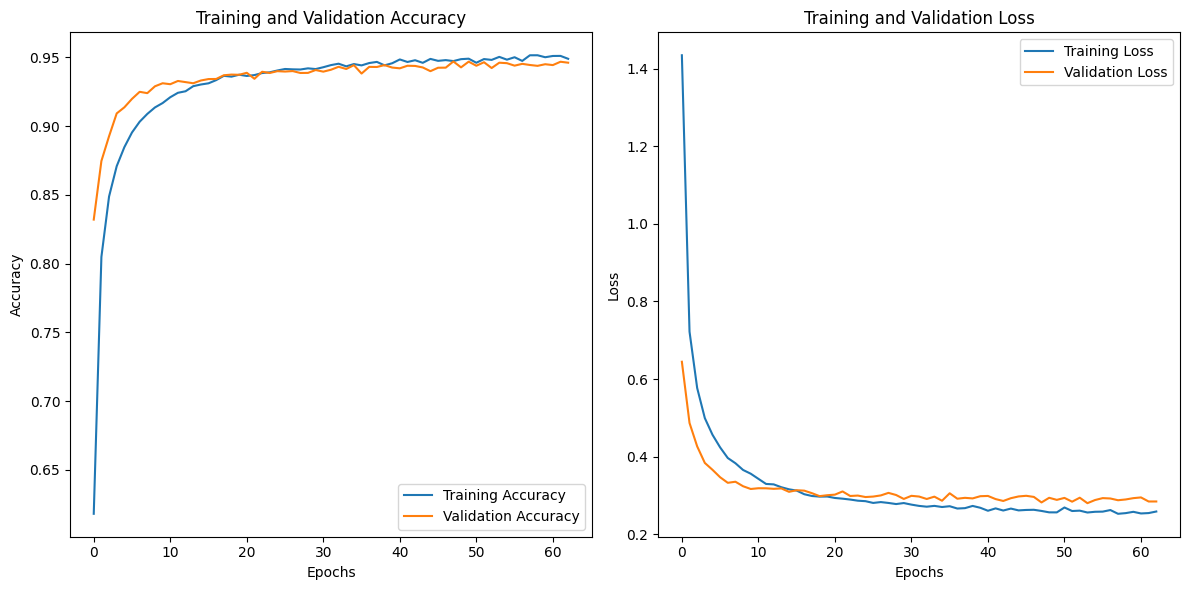

In [58]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

Overfitting seems mostly gone. Of course the amount of overfitting that can be displayed in the plots differs each run, because of the randomness involved in the training (e.g. dropouts) so it's hard to fine tune it perfectly (it also requires many runs that are quite slow on a model this big).

In [59]:
# Print classification report
print(classification_report(y_val_labels, y_pred3))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       484
           1       0.84      0.85      0.85        74
           2       0.92      0.95      0.93       424
           3       0.96      0.92      0.94       364
           4       0.96      0.94      0.95       364
           5       0.91      0.95      0.93       112
           6       0.93      0.94      0.94       396
           7       0.94      0.82      0.88       114
           8       0.91      0.93      0.92       418
           9       0.97      0.98      0.98       445
          10       0.98      0.98      0.98       524
          11       0.95      0.94      0.95       150
          12       0.90      0.93      0.91        69
          13       0.95      0.96      0.96       124
          14       0.97      0.96      0.97       397
          15       0.98      0.98      0.98       449
          16       0.90      0.96      0.93        68
          17       0.94    

The preformance is pretty much identical. I have run many variations of the model, but I wasn't able to reach better performance.

There could be a few reasons for this:
*   While dropouts help prevent overfitting, they also reduces the overall capacity of the model, so the model may end up underfitting slightly.
*   The noise introduced by dropouts during training can slow convergence or cause a slight performance dip if not balanced perfectly.
* Successfully eliminating overfitting with dropouts doesn’t mean that the model was tuned optimally. As I already said, it is not easy to tune it perfectly because that requires a high amount of test runs.
* Using both L2 regularization and dropout together may lead to over-regularization, causing the model to struggle to converge.
* Is could, simply, be the limitation of the model's structure and the approach that was taken (as I described before, there are many different approaches that could work much better, but I decided to not attempt in order to not over-complicate the assignment)


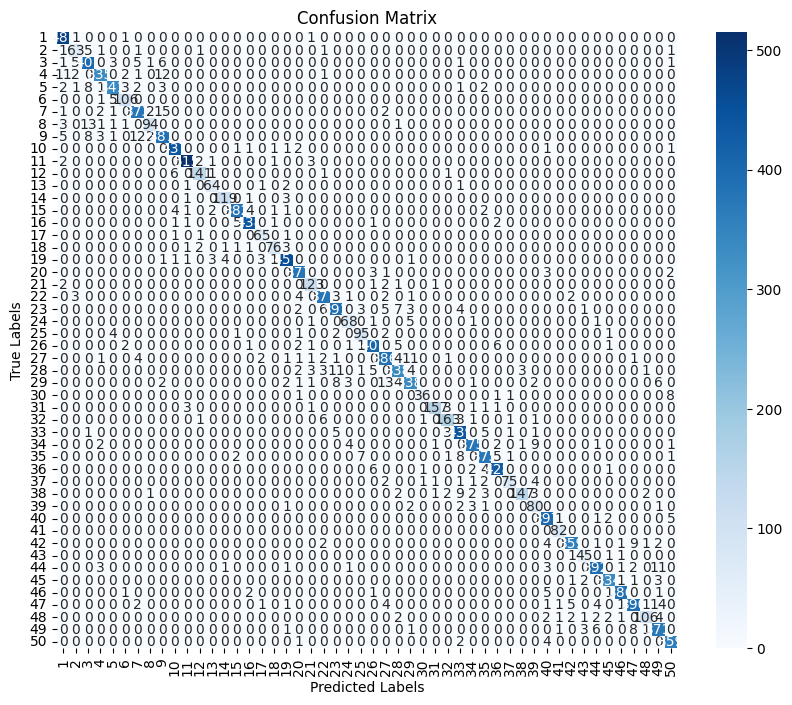

In [60]:
# Compute confusion matrix
cm3 = confusion_matrix(y_val_labels, y_pred3)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1, 51), yticklabels=np.arange(1, 51))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

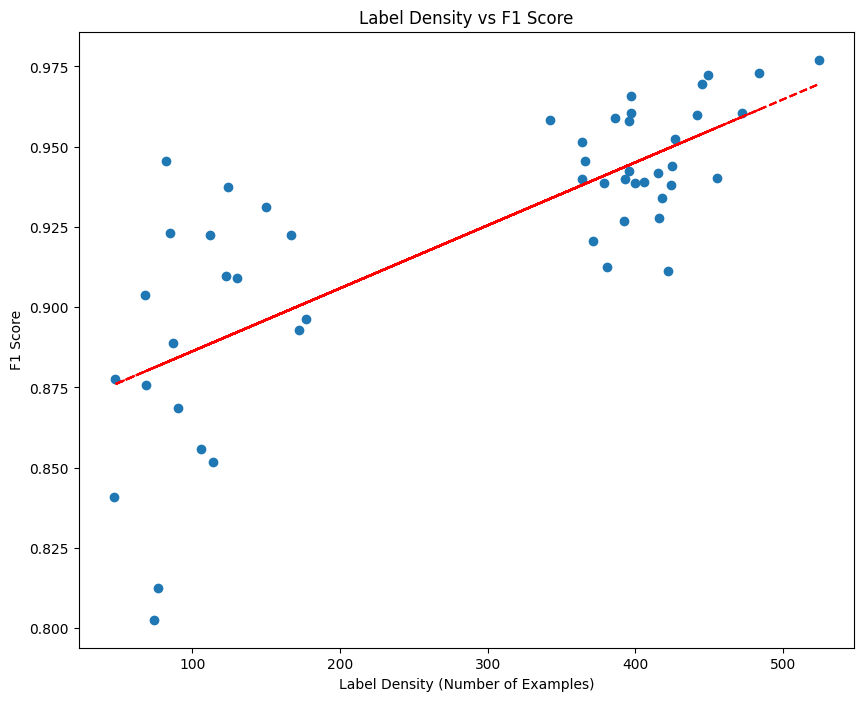

In [61]:
# Get the classification report
report = classification_report(y_val_labels, y_pred, output_dict=True)

# Extract the label names, F1 scores, and support (label density)
labels = list(report.keys())[:-3]
f1_scores = [report[label]['f1-score'] for label in labels]
supports = [report[label]['support'] for label in labels]

# Create the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(supports, f1_scores)

# Add labels and title
plt.xlabel('Label Density (Number of Examples)')
plt.ylabel('F1 Score')
plt.title('Label Density vs F1 Score')

# Add a trend line
z = np.polyfit(supports, f1_scores, 1)
p = np.poly1d(z)
plt.plot(supports, p(supports), color='r', linestyle='--')

# Show the plot
plt.show()

The underrepresentation problem is still there but, as I already explained, this can't be fixed easily.

## 1.3. Compare the performances of the two models (non-regularized and regularized) on the provided test set, visualize and comment on theresults

Visualize, describe and interpret the evaluation procedure and results on the provided test set, with a focus on the generalization capability of your models.



In [62]:
# Get predictions (probabilities) from the model
y_test_pred_prob_1 = model.predict(X_test)
y_test_pred_prob_3 = model3.predict(X_test)

# Convert probabilities to predicted class labels (the class with the highest probability)
y_test_pred_1 = np.argmax(y_test_pred_prob_1, axis=1)  # Get the index of the class with the highest probability
y_test_pred_3 = np.argmax(y_test_pred_prob_3, axis=1)

# Convert y_test (one-hot encoded) to class labels
y_test_labels = np.argmax(y_test, axis=1)

753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [63]:
accuracy = accuracy_score(y_test_labels, y_test_pred_1)
print(f"Classification accuracy: {accuracy:.4f}")
print(classification_report(y_test_labels, y_test_pred_1))

Classification accuracy: 0.9369
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       801
           1       0.74      0.83      0.78        77
           2       0.93      0.94      0.94       638
           3       0.96      0.93      0.95       676
           4       0.94      0.96      0.95       606
           5       0.97      0.95      0.96       188
           6       0.92      0.94      0.93       697
           7       0.89      0.82      0.85       185
           8       0.91      0.92      0.92       667
           9       0.97      0.97      0.97       771
          10       0.99      0.98      0.98       876
          11       0.94      0.94      0.94       261
          12       0.84      0.90      0.87        82
          13       0.90      0.90      0.90       202
          14       0.95      0.97      0.96       687
          15       0.98      0.97      0.98       751
          16       0.91      0.85      0.88      

In [64]:
accuracy = accuracy_score(y_test_labels, y_test_pred_3)
print(f"Classification accuracy: {accuracy:.4f}")
print(classification_report(y_test_labels, y_test_pred_3))

Classification accuracy: 0.9472
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       801
           1       0.80      0.77      0.78        77
           2       0.94      0.94      0.94       638
           3       0.95      0.97      0.96       676
           4       0.95      0.96      0.95       606
           5       0.96      0.97      0.97       188
           6       0.94      0.94      0.94       697
           7       0.91      0.88      0.89       185
           8       0.93      0.93      0.93       667
           9       0.96      0.98      0.97       771
          10       0.98      0.99      0.98       876
          11       0.96      0.96      0.96       261
          12       0.84      0.89      0.86        82
          13       0.91      0.92      0.91       202
          14       0.97      0.96      0.97       687
          15       0.97      0.98      0.98       751
          16       0.94      0.88      0.91      

The performance of the two models on the test set is pretty much identical across the board. This was highly expected, since the dataset is big enough where we can expect every subset to have the same distribution of labels (if they were divided randomly).

As before, we can clearly see how most of the classes with a lower accuracy appear to be the classes with the least support samples (as they were in the training set, so this causes underrapresentation, in this case there simply aren't enough examples to describe those classes properly).

The fact that the different averages are very similar supports my thesis: the problem isn't the unbalance itself, it's the lack of examples that doesn't give the model enough information about some classes.

The performance is overall good though. The second model is preferable, since it doesn't overfit the training data.

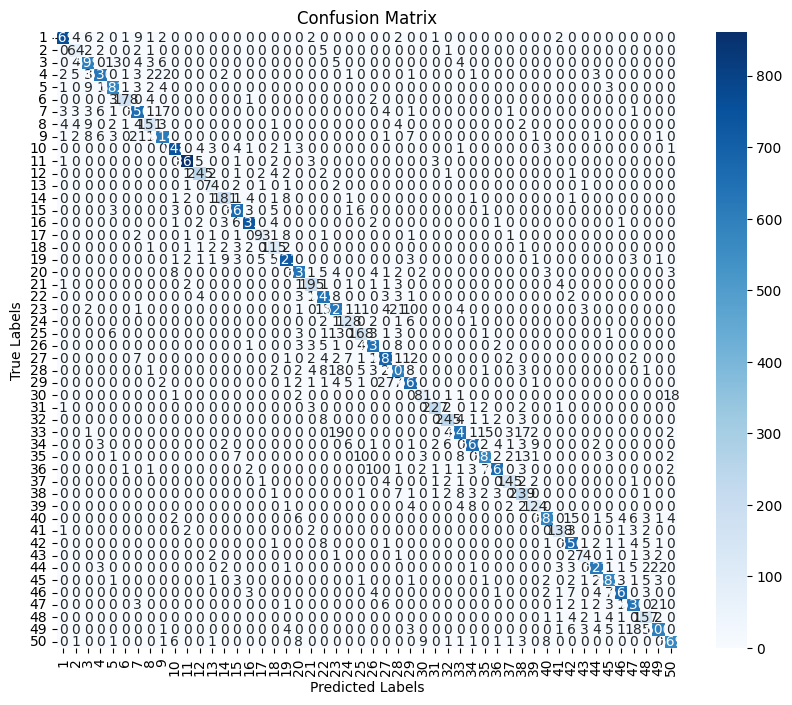

In [65]:
# Compute confusion matrix
cm3 = confusion_matrix(y_test_labels, y_test_pred_1)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1, 51), yticklabels=np.arange(1, 51))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

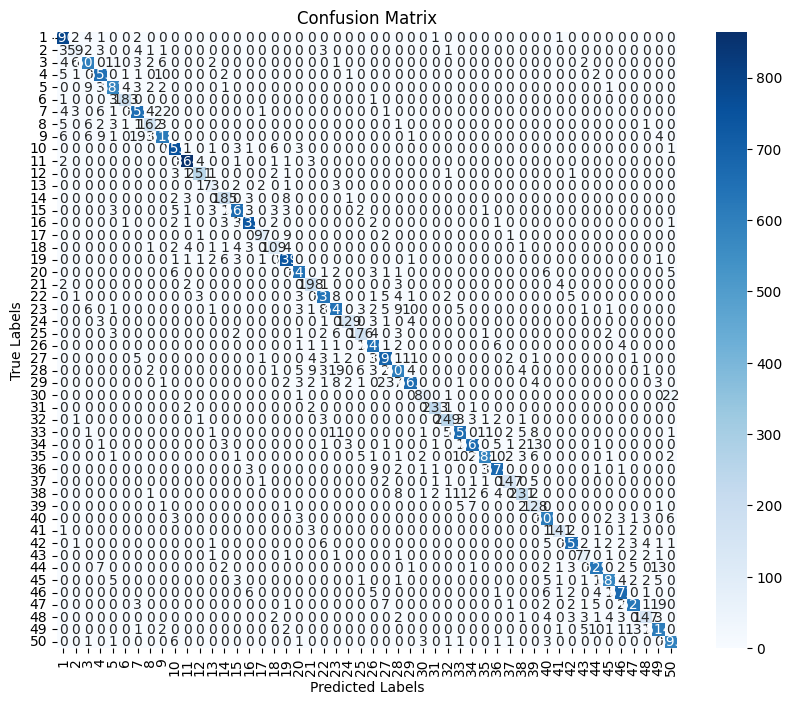

In [66]:
# Compute confusion matrix
cm3 = confusion_matrix(y_test_labels, y_test_pred_3)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1, 51), yticklabels=np.arange(1, 51))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

These confusion matrixes can be hard to read because of their size, but we can see how they are very similar.

In both models, it seems like a lot of the misclassifications happen while still getting one of the two numbers correct.

In [67]:
def quantify_predictions(y_true, y_pred):
    correct = 0
    wrong = 0
    partially_correct = 0

    for true_label, pred_label in zip(y_true, y_pred):
        # Convert labels and predictions to strings to easily compare individual digits
        true_label_str = str(true_label)
        pred_label_str = str(pred_label)

        # Ensure they are two digits (you may need to adjust this based on your data)
        true_label_str = true_label_str.zfill(2)  # Adds leading zeros if necessary
        pred_label_str = pred_label_str.zfill(2)

        # Check if the prediction matches the true label exactly
        if pred_label_str == true_label_str:
            correct += 1
        # Check if at least one digit matches
        elif any(digit in true_label_str for digit in pred_label_str):
            partially_correct += 1
        else:
            wrong += 1

    total = len(y_true)

    # Calculate percentages
    correct_percentage = (correct / total) * 100
    partially_correct_percentage = (partially_correct / total) * 100
    wrong_percentage = (wrong / total) * 100

    return correct, partially_correct, wrong, correct_percentage, partially_correct_percentage, wrong_percentage

# Example usage (replace y_test_labels and y_test_pred_3 with your actual data)
correct, partially_correct, wrong, correct_percentage, partially_correct_percentage, wrong_percentage = quantify_predictions(y_test_labels, y_test_pred_3)

print(f"Correct Predictions: {correct} ({correct_percentage:.2f}%)")
print(f"Partially Correct Predictions (One Digit Correct): {partially_correct} ({partially_correct_percentage:.2f}%)")
print(f"Wrong Predictions: {wrong} ({wrong_percentage:.2f}%)")

Correct Predictions: 22811 (94.72%)
Partially Correct Predictions (One Digit Correct): 1167 (4.85%)
Wrong Predictions: 105 (0.44%)


I decided to investigate it a bit more, to get some actual metrics. Here we can see that there is a good number of cases where at least one of the two numbers was guessed correctly, only rarely the model gets both wrong.

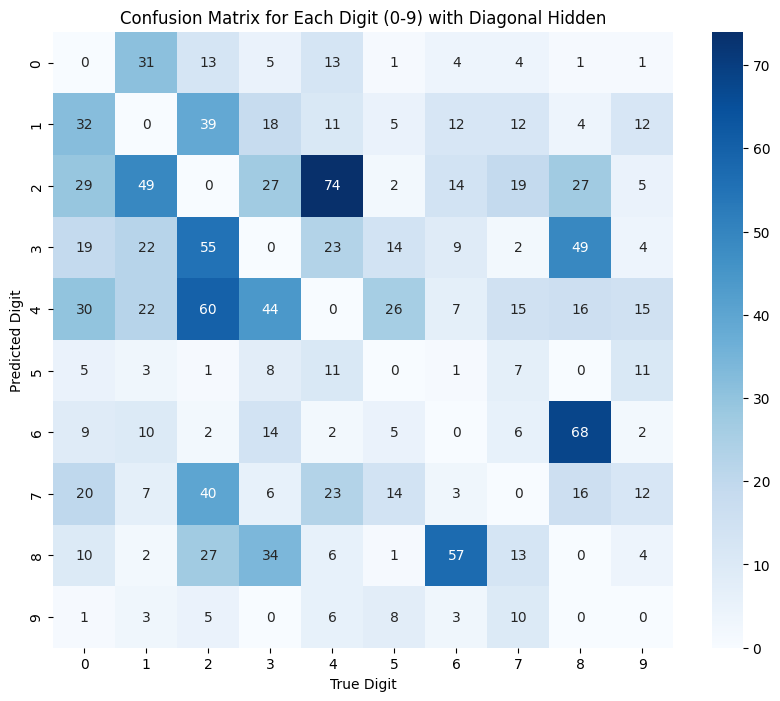

In [68]:
# Initialize confusion matrix for digits (0-9)
confusion_matrix = np.zeros((10, 10), dtype=int)

def update_confusion_matrix(pred_digit, real_digit):
    # Update the confusion matrix for the digit pair (pred_digit vs. real_digit)
    confusion_matrix[pred_digit][real_digit] += 1

# Update the confusion matrix for each pair of prediction and real value
for pred, real in zip(y_test_labels, y_test_pred_3):
    # Convert numbers to strings and pad with leading zeros to ensure they are 2 digits
    pred_str = str(pred).zfill(2)
    real_str = str(real).zfill(2)

    # Compare tens and ones digits
    for p_digit, r_digit in zip(pred_str, real_str):
        update_confusion_matrix(int(p_digit), int(r_digit))

# Set the diagonal elements of the confusion matrix to zero
np.fill_diagonal(confusion_matrix, 0)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=np.arange(0, 10), yticklabels=np.arange(0, 10))

# Add labels and title
plt.xlabel('True Digit')
plt.ylabel('Predicted Digit')
plt.title('Confusion Matrix for Each Digit (0-9) with Diagonal Hidden')
plt.show()


To go even deeper, I considered every digit singularly. Here we can see which numbers are most often confused: 6 and 8, 3 and 8, 2 and 5. Of course this makes sense, becasue they can look alike if not written perfectly well.

# 2. The development of a simple auto-encoder model  [Mandatory]
Implement a fully-connected AutoEncoder architecuture, with a **compression factor** (ratio between input size and smallest encoding size) in the **range [20-30]**.


Visually investigate the reconstruction abilities of such an architecture, e.g. comparing a few inputs and outputs (reconstructed inputs) of the model (as seen in class).

## 2.1 Building the network

note: although not strictly required, monitoring the training dynamics and performance evaluation is suggested for the autoencoder model.

In [14]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

encoding_dim = 42
activation = "relu"
input_shape = X_train.shape[1]

input = Input(shape=(input_shape,))

# downsampling hidden layers
downsampling_hidden_1 = Dense(512, activation = activation, name = "downsampling_hidden_1")(input)
downsampling_hidden_2 = Dense(256, activation = activation, name = "downsampling_hidden_2")(downsampling_hidden_1)
downsampling_hidden_3 = Dense(128, activation = activation, name = "downsampling_hidden_3")(downsampling_hidden_2)

encoded = Dense(encoding_dim, activation=activation, name = "latent")(downsampling_hidden_3)

# upsampling hidden layers
upsampling_hidden_1 = Dense(128, activation = activation, name = "upsampling_hidden_1")(encoded)
upsampling_hidden_2 = Dense(256, activation = activation, name = "upsampling_hidden_2")(upsampling_hidden_1)
upsampling_hidden_3 = Dense(512, activation = activation, name = "upsampling_hidden_3")(upsampling_hidden_2)

decoded = Dense(input_shape, activation='sigmoid', name = "decoder")(upsampling_hidden_3)

autoencoder = Model(input, decoded)

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1092)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ downsampling_hidden_1 (Dense)        │ (None, 512)                 │         559,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ downsampling_hidden_2 (Dense)        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ downsampling_hidden_3 (Dense)        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent (Dense)                       │ (None, 42)                  │           5,418 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ upsampling_hidden_1 (Dense)          │ (None, 128)                 │           5,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ upsampling_hidden_2 (Dense)          │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ upsampling_hidden_3 (Dense)          │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Dense)                      │ (None, 1092)                │         560,196 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,459,566 (5.57 MB)

 Trainable params: 1,459,566 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

The compression factor is calculate as (input_size / encoding size), so in this case (1092 / 42) = 26

I have tried different model with different amounts of layers and neurons, this seems to be a good compromise between performance and model size.

I used relu since it's a good starting point and a good choice for networks with multiple layers. Sigmoid outputs a continuous number between 0 and 1, which is what I was looking for.

## 2.2 Visually Inspecting the results

Investigate the reconstruction capabilities of autoencoders by comparing (in a multi-column plot) the visual representation of some input data (5 to 10 samples) with the reconstruction of such samples (output of the autoencoder).

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Compile and fit the autoencoder
autoencoder.compile(optimizer="adam", loss='mse', metrics=["mse"])
autoencoder_history = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=50,
    batch_size=128,
    shuffle=True,
    callbacks=[early_stopping]
)

Epoch 1/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 26s 50ms/step - loss: 0.0817 - mse: 0.0817 - val_loss: 0.0384 - val_mse: 0.0384
Epoch 2/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0301 - val_mse: 0.0301
Epoch 3/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 0.0285 - mse: 0.0285 - val_loss: 0.0259 - val_mse: 0.0259
Epoch 4/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - loss: 0.0251 - mse: 0.0251 - val_loss: 0.0238 - val_mse: 0.0238
Epoch 5/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - loss: 0.0228 - mse: 0.0228 - val_loss: 0.0223 - val_mse: 0.0223
Epoch 6/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - loss: 0.0213 - mse: 0.0213 - val_loss: 0.0209 - val_mse: 0.0209
Epoch 7/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - loss: 0.0203 - mse: 0.0203 - val_loss: 0.0204 - val_mse: 0.0204
Epoch 8/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 39s 43ms/step - loss: 0.0194 - mse: 0.0194 - val_loss: 0.0194 - val_mse: 0.0194
Epoch 9/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 

I started with binary_crossentropy as loss, but during testing I found that mean squared error worked slighlty better and reached slightly better results. I also tried to use mae but it doesn't work, because it doesn't handle well significant local variations of value (like at edges of the number).

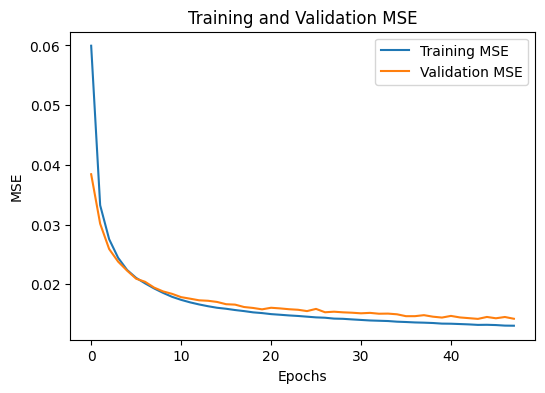

In [16]:
# Plot training & validation metrics
plt.figure(figsize=(6, 4))

# Plot for MSE (mean squared error)
plt.plot(autoencoder_history.history['mse'], label='Training MSE')
plt.plot(autoencoder_history.history['val_mse'], label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

# Show the plot
plt.show()

753/753 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step
MSE for image 1: 0.0107
MSE for image 2: 0.0110
MSE for image 3: 0.0166
MSE for image 4: 0.0054
MSE for image 5: 0.0140


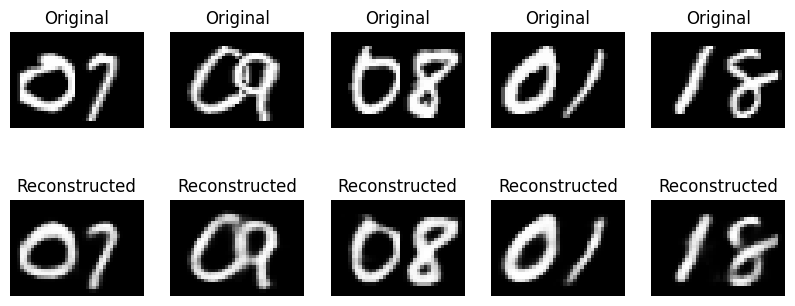

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Get the model's reconstruction of X_test
reconstructed_images = autoencoder.predict(X_test)

# Display the first 5 images from X_test and their corresponding reconstructions
n = 5
plt.figure(figsize=(10, 4))

for i in range(n):
    # Original Image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 39), cmap="gray")
    ax.set_title("Original")
    ax.axis("off")

    # Reconstructed Image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].reshape(28, 39), cmap="gray")
    ax.set_title("Reconstructed")
    ax.axis("off")

    # Calculate the Mean Squared Error for the current image
    mse = mean_squared_error(X_test[i].reshape(28, 39), reconstructed_images[i].reshape(28, 39))
    print(f"MSE for image {i + 1}: {mse:.4f}")

plt.show()


The reconstruction seems quite decent, the mse values indicate a relatively small error and good reconstruction overall. There is loss in sharpness, the new image seem to be more smooth and more rounded (especially the 8s).

## 2.3 Generate new samples

Starting from random encodings, generate $N$ ($N \in [10,20]$) new samples, and make some comments about the quality and distribution of the generated samples.

In [18]:
# encoder model, I put it here for completeness, but it's not used.
encoder_model = Model(input, encoded)
encoder_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1092)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ downsampling_hidden_1 (Dense)        │ (None, 512)                 │         559,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ downsampling_hidden_2 (Dense)        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ downsampling_hidden_3 (Dense)        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent (Dense)                       │ (None, 42)                  │           5,418 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 729,258 (2.78 MB)

 Trainable params: 729,258 (2.78 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# decoder model
decoder_model = Model(encoded, decoded)

decoder_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ keras_tensor_4CLONE (InputLayer)     │ (None, 42)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ upsampling_hidden_1 (Dense)          │ (None, 128)                 │           5,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ upsampling_hidden_2 (Dense)          │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ upsampling_hidden_3 (Dense)          │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Dense)                      │ (None, 1092)                │         560,196 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 730,308 (2.79 MB)

 Trainable params: 730,308 (2.79 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


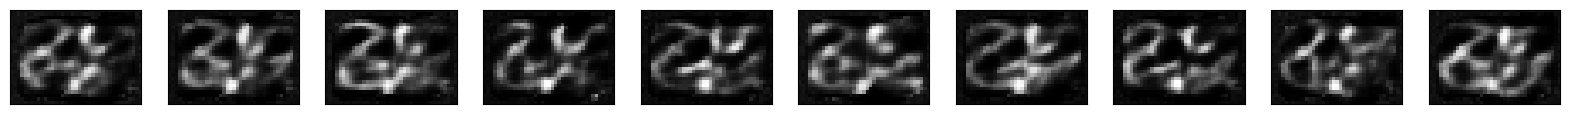

In [20]:
N = 10  # number of images to generate

# Generate random vectors (samples from a normal distribution)
random_latent_vectors = np.random.normal(size=(N, encoding_dim))

# Pass random vectors through the decoder to generate new samples
generated_samples = decoder_model.predict(random_latent_vectors)

plt.figure(figsize=(20, 4))
for i in range(N):
    ax = plt.subplot(2, N, i + 1 + N)
    plt.imshow(generated_samples[i].reshape(28, 39))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

From these results are not good, but still, we can see that they are not completely random, there is come coherence.

Although most of them don't resamble numbers too much, we can see how the model did generate patterns that are somewhat consistent with the input dataset, because it created lines that could resamble scribbles (instead of random blurs for example). The images also have a lof of black space, especially on the outside, and somewhat defined borders of the "numbers", just like the dataset.

# 3.A [OPTIONAL] The use and evaluation of the latent (encoded) representations generated by the auto-encoder to solve the problem of supervised classification.

1. Obtain `X_train_encoded`, `X_test_encoded`, the latent (encoded) representations of `X_train` and `X_test` generated by the (encoder module of the) autoencoder developed in Section 2.

2. With the use of any classic machine learning method of your choice (avoid NNs), classify letters as in Sec.1 based on this representation.

3. Apply the same type of ML algorithm chosen in pt.2, but directly on the original data `X_train`, `X_test` (or you can use suitable dimensionality reduction methods if the chosen algorithm is known to require them or benefit from them).  

4. Compare (briefly) the performances on the test set, between the best model of Sec.1, the ML model trained on `X_train_encoded` and the ML model trained on `X_train` (or any other suitable representation that you choose in pt.3).


In other words, instead of feeding images directly through a classifier, you can try to use the encoded representations from the AE as input for a classic ML algorithm (XGB, SVM, RF ...) to solve the classification task.


## Models

In [27]:
# Obtain the encoded representations for X_train and X_test
X_train_encoded = encoder_model.predict(X_train)
X_test_encoded = encoder_model.predict(X_test)

1807/1807 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


This encodes the training set, using the encoder. The encoded instances now have 42 features, instead of 1092. This is the feature reduction effect.

In [69]:
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Convert one-hot encoded labels back to integer labels
Y_train_int = np.argmax(y_train, axis=1)
Y_test_int = np.argmax(y_test, axis=1)

# Initialize and train the SVM classifier
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_classifier.fit(X_train_encoded, Y_train_int)

# Predict using the SVM classifier on the test set
Y_pred = svm_classifier.predict(X_test_encoded)

# Evaluate the performance of the SVM classifier
accuracy = accuracy_score(Y_test_int, Y_pred)
print(f"Classification accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(Y_test_int, Y_pred))

Classification accuracy: 0.8842

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95       801
           1       0.81      0.55      0.65        77
           2       0.88      0.87      0.88       638
           3       0.89      0.92      0.91       676
           4       0.87      0.90      0.88       606
           5       0.87      0.91      0.89       188
           6       0.88      0.88      0.88       697
           7       0.88      0.74      0.80       185
           8       0.86      0.85      0.86       667
           9       0.92      0.95      0.93       771
          10       0.96      0.98      0.97       876
          11       0.90      0.86      0.88       261
          12       0.81      0.73      0.77        82
          13       0.84      0.82      0.83       202
          14       0.87      0.92      0.90       687
          15       0.93      0.96      0.94       751
          16       0.92 

The results above are regarding the SVM with the encoded dataset. This and the other SVM models could be improved by using the validation set to do a GridSearchCV cross-validation (this is why I haven't re-united the training set, whoever training these models takes a considerable amount of time after you run out of GPU time so I haven't applied the cross validation)

Number of components to retain up to the elbow point: 126
Variance at elbow point (cumulative): 0.9001
Variance at first 42 components (cumulative): 0.6999


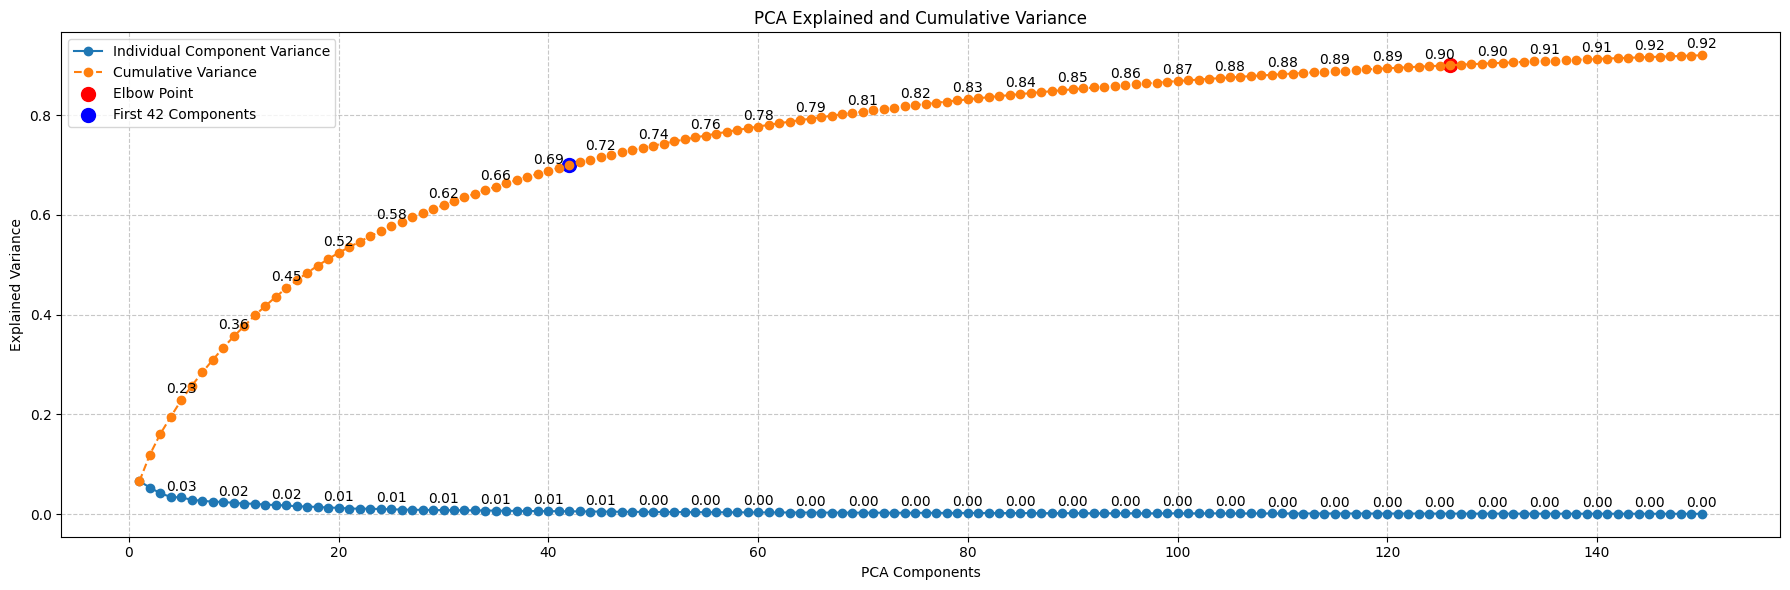

In [29]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Assume X_train is defined (the input data matrix)
pca = PCA(n_components=150)  # Reduce to the top components
X_train_reduced = pca.fit_transform(X_train)

# Calculate cumulative variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

fig, ax = plt.subplots(figsize=(18, 6))

# Plot variance explained by each component
ax.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', label='Individual Component Variance')

# Plot cumulative variance
ax.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', label='Cumulative Variance')

# Calculate and mark elbow point
elbow_point = np.argmax(np.diff(cumulative_variance) < 0.001) + 1
ax.scatter(elbow_point, cumulative_variance[elbow_point - 1], s=100, color='red', marker='o', label='Elbow Point')

# Mark the point for retaining the first 42 components
first_42_point = 42
ax.scatter(first_42_point, cumulative_variance[first_42_point - 1], s=100, color='blue', marker='o', label='First 42 Components')

# Print the number of components and cumulative variance at the elbow and first 42 components
print(f"Number of components to retain up to the elbow point: {elbow_point}")
print(f"Variance at elbow point (cumulative): {cumulative_variance[elbow_point - 1]:.4f}")
print(f"Variance at first 42 components (cumulative): {cumulative_variance[first_42_point - 1]:.4f}")

# Chart labels and title
ax.set_xlabel('PCA Components')
ax.set_ylabel('Explained Variance')
ax.set_title('PCA Explained and Cumulative Variance')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)

# Annotate variance values for every 5th component
for i, txt in enumerate(pca.explained_variance_ratio_):
    if (i + 1) % 5 == 0:  # Only annotate every 5th component
        ax.annotate(f'{txt:.2f}', (i + 1, txt), textcoords="offset points", xytext=(0, 5), ha='center')
for i, txt in enumerate(cumulative_variance):
    if (i + 1) % 5 == 0:  # Only annotate every 5th component
        ax.annotate(f'{txt:.2f}', (i + 1, txt), textcoords="offset points", xytext=(0, 5), ha='center')

plt.tight_layout()
plt.show()


The elbow point describes the first point where the change in cumulative variance drops below 0.001 when moving from one component to the next, and in this case it describes about 90% of the variance of the dataset.

Usually you take the elbow point as a cutoff point for the components, however in this case (for comparison purposes) I've decided to take the first 42 components, to basically have in both cases a dimensionality reduction to 42 features. These 42 components explain about 70% of the dataset's variance.

In [30]:
# Use the first 42 components
pca = PCA(n_components=42)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# Initialize and train the SVM classifier
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_classifier.fit(X_train_reduced, Y_train_int)

# Predict using the SVM classifier on the test set
Y_pred = svm_classifier.predict(X_test_reduced)

# Evaluate the performance of the SVM classifier
accuracy = accuracy_score(Y_test_int, Y_pred)
print(f"Classification accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(Y_test_int, Y_pred))

Classification accuracy: 0.8938

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95       801
           1       0.79      0.60      0.68        77
           2       0.90      0.89      0.89       638
           3       0.89      0.92      0.90       676
           4       0.91      0.89      0.90       606
           5       0.91      0.93      0.92       188
           6       0.89      0.90      0.89       697
           7       0.92      0.77      0.84       185
           8       0.85      0.85      0.85       667
           9       0.95      0.96      0.95       771
          10       0.96      0.98      0.97       876
          11       0.90      0.89      0.89       261
          12       0.79      0.72      0.75        82
          13       0.87      0.85      0.86       202
          14       0.90      0.95      0.92       687
          15       0.94      0.97      0.95       751
          16       0.85 

The results above are regarding the SVM with the PCA-reduced dataset.

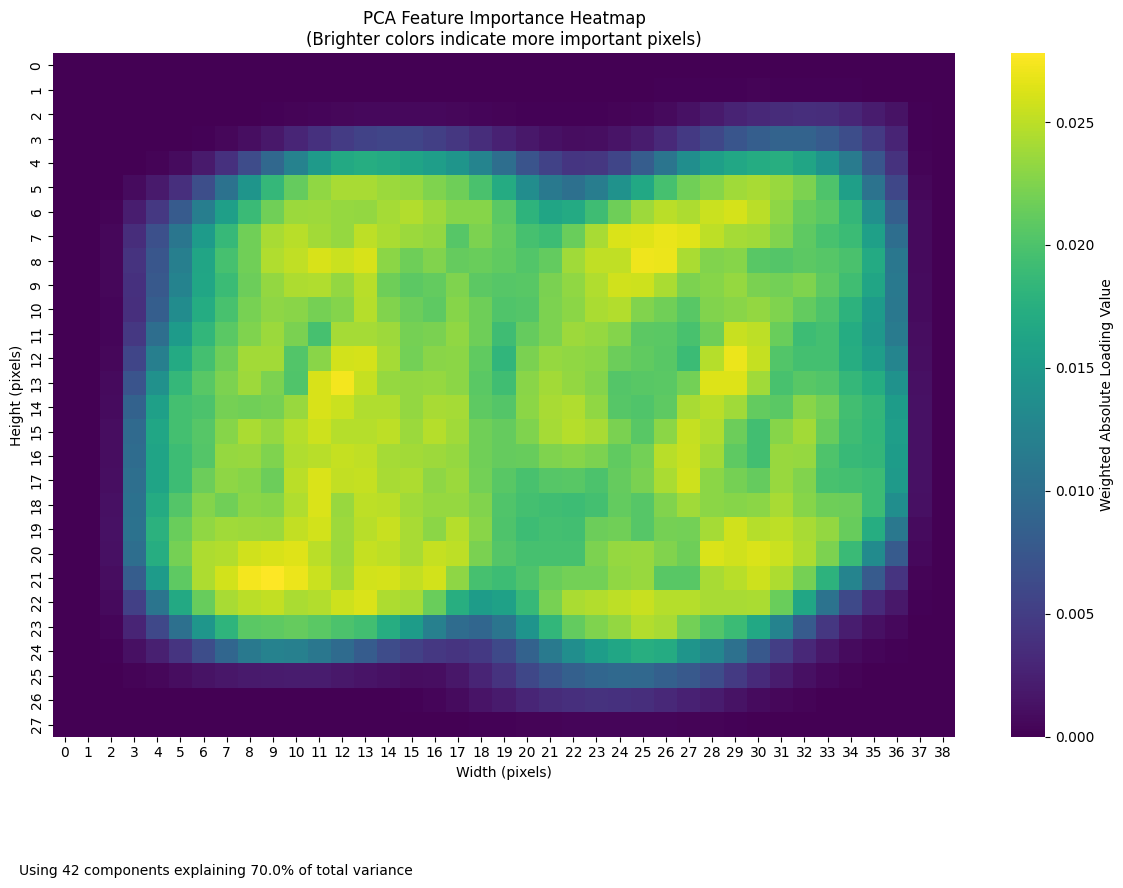

Number of components used: 42
Cumulative explained variance: 69.984%


In [32]:
import seaborn as sns

# Get the loadings and weight them by their explained variance ratio
n_features = X_train.shape[1]
weighted_loadings = np.zeros(n_features)
for i, (loading, ratio) in enumerate(zip(pca.components_, pca.explained_variance_ratio_)):
    weighted_loadings += np.abs(loading) * ratio

# Reshape loadings to match image dimensions
importance_image = weighted_loadings.reshape(28, 39)

# Create the visualization
plt.figure(figsize=(12, 8))

# Plot heatmap
sns.heatmap(importance_image,
            cmap="viridis",
            annot=False,
            cbar_kws={'label': 'Weighted Absolute Loading Value'})

plt.title("PCA Feature Importance Heatmap\n(Brighter colors indicate more important pixels)")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")

# Add information about components used
n_components_used = len(pca.explained_variance_ratio_)
total_variance = np.sum(pca.explained_variance_ratio_)
plt.figtext(0.02, -0.1,
            f"Using {n_components_used} components explaining {total_variance:.1%} of total variance",
            fontsize=10)

plt.tight_layout()
plt.show()

# Optional: Print number of components and cumulative explained variance
print(f"Number of components used: {n_components_used}")
print(f"Cumulative explained variance: {total_variance:.3%}")

Here I have displayed a heatmap that describes the importance that each pixel has, in the top 42 PCA components. The reuslt is highly expected, as most images don't have any information in the edge-pixels.

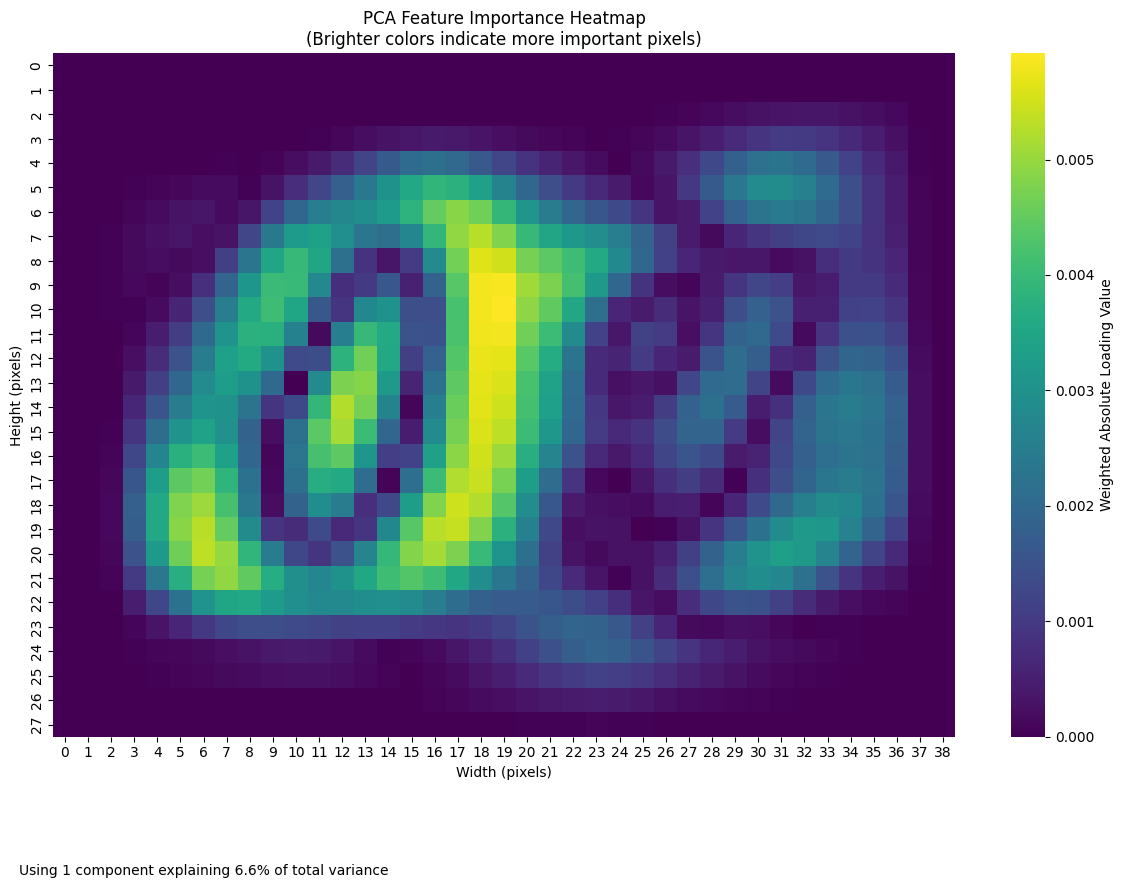

Number of components used: 1
Explained variance for the first component: 6.596%


In [71]:
# Get the loadings of the first component and weight them by its explained variance ratio
first_loading = np.abs(pca.components_[0])  # First component loadings (absolute values)
explained_variance_ratio_first = pca.explained_variance_ratio_[0]  # Explained variance ratio of the first component

# Weight the loadings by the explained variance ratio of the first component
weighted_loadings = first_loading * explained_variance_ratio_first

# Reshape loadings to match image dimensions
importance_image = weighted_loadings.reshape(28, 39)

# Create the visualization
plt.figure(figsize=(12, 8))

# Plot heatmap
sns.heatmap(importance_image,
            cmap="viridis",
            annot=False,
            cbar_kws={'label': 'Weighted Absolute Loading Value'})

plt.title("PCA Feature Importance Heatmap\n(Brighter colors indicate more important pixels)")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")

# Add information about the first component
plt.figtext(0.02, -0.1,
            f"Using 1 component explaining {explained_variance_ratio_first:.1%} of total variance",
            fontsize=10)

plt.tight_layout()
plt.show()

# Optional: Print information about the first component
print(f"Number of components used: 1")
print(f"Explained variance for the first component: {explained_variance_ratio_first:.3%}")


Only considering the first component actually shows a more interesting heatmap. It's quite clear how numbers have a mix of rounded shapes and straight lines in the middle, so these areas are more important, and give more information. It's also interesting that the left side of the image seems to be more important.

In [33]:
pca = PCA(n_components=elbow_point)  # Use the number of components up to the elbow point
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# Initialize and train the SVM classifier
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_classifier.fit(X_train_reduced, Y_train_int)

# Predict using the SVM classifier on the test set
Y_pred = svm_classifier.predict(X_test_reduced)

# Evaluate the performance of the SVM classifier
accuracy = accuracy_score(Y_test_int, Y_pred)
print(f"Classification accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(Y_test_int, Y_pred))

Classification accuracy: 0.9037

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       801
           1       0.82      0.58      0.68        77
           2       0.89      0.90      0.90       638
           3       0.89      0.93      0.91       676
           4       0.91      0.89      0.90       606
           5       0.91      0.92      0.91       188
           6       0.90      0.91      0.90       697
           7       0.91      0.74      0.81       185
           8       0.88      0.87      0.87       667
           9       0.95      0.97      0.96       771
          10       0.97      0.98      0.97       876
          11       0.90      0.89      0.89       261
          12       0.81      0.77      0.79        82
          13       0.89      0.83      0.86       202
          14       0.91      0.95      0.93       687
          15       0.95      0.97      0.96       751
          16       0.90 

For comparison's sake, I also trained the SVM above to use all the components up until the elbow point (126 components that describe 90% of the dataset's variance)

 ## Comparisons on the test set

**Test set comparisons**

|| Regularized NN model | Encoded SVM model | PCA SVM model | PCA SVM model 2|
|----------|-------------------|----------|----------|----------|
|**Description**| 1092 features (every pixel)| 42 features encoded by the encoder  | Top 42 components of the PCA  | Top 126 components of the PCA
|**Accuracy**|95%           |88%   | 89%  | 90%  |
|**Macro average**| 93%           | 85%  | 86%  | 87%  |
|**Weighted average**| 95%           | 88%  | 89%  | 90%  |

The regularized NN model performs the best (95% accuracy) because it uses all 1092 pixel features, allowing it to capture complex patterns.

The encoded SVM (42 features from the autoencoder) performs considerably worse (88% accuracy) because the encoder reduces the feature space dramatically (from 1092 features to 42), potentially losing important information.

The PCA SVM with 42 components (89% accuracy) offers slightly better performance than the encoded SVM. This indicates that the feature detector effect of the autoencoder is actually not bad. I believe that at least in theory, tweaking the autoencoder (for example by using different activation functions, adding regularization, or increasing layers) could result in a better feature reduction result, that would work better than the PCA. Also, the autoencoder has advantages over PCA because it can learn non-linear mappings from the data, allowing it to capture more complex patterns and relationships that PCA (which is linear) can't. However, because of how long it takes to train an autoencoder model without GPU time, I will not explore this option.

Using 126 PCA components (90% accuracy) improves performance slightly, as it captures more variance (90% instead of 70%), but still not much relatively to the previous PCA SVM model,if you consider that the number of featues has almost tripled.

# 3.B [OPTIONAL] Explain model's predictions

Take the networks defined in (1) and try to explain the predictions of the model.

*   Include at least one model-agnostic method and one model-specific method;
*   Compare the two investigated XAI methods;
*   Compare the results on the original and regularized model for a single XAI method;

### 3.B.1 XAI method definition

Describe the design choices made at this stage: why did you choose these two methods?

### 3.B.2 Result's comparison

Compare the results of both XAI methods and the results of applying the same method to different models.